# Procedural

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U torchtext==0.10.0
!pip install -U torch==1.9.0

In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
from torchtext.legacy import data
import numpy as np
import spacy
import spacy.cli
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
import random

spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
RANDOM_SEED = 42

# Load from other notebooks

In [5]:
DISCARD_NUMBERS = True
BATCH_SIZE = 16
LENGTH_TO_TRUNCATE_POSTS = 200

In [6]:
spacy_eng = spacy.load('en')

In [7]:
def generate_example_comment(model, batch, field, num_coms_to_gen=2):
    '''
    Function that takes in a trained model and a batch of posts with comments and generates a few new comments from posts
    '''
    src = batch.src.to(device)
    trg = batch.trg.to(device)

    model = model.eval()
    with torch.no_grad():
        outputs = model(src, trg)

    for i in range(0, num_coms_to_gen):
        output_seq_ex = outputs[:, i, :]
        best_guess_for_ex_seq = [int(row.argmax()) for row in output_seq_ex]
        print([field.vocab.itos[idx] for idx in best_guess_for_ex_seq])
    
    pass

In [8]:
class Encoder(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, p_drop, is_bidirectional, train_embeddings):
        super(Encoder, self).__init__()

        # Instantiate straightforward attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p_drop)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.train_embeddings = train_embeddings
        self.is_bidirectional = is_bidirectional
        
        # Freeze the embeddings if desired
        if not self.train_embeddings:
            self.embedding.weight.requires_grad = False

        # Instantiate the lstm of the encoder
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p_drop, bidirectional=self.is_bidirectional)

        # Kind of an fc layer that will pick whether to propagate to attention the info of the forward or the backward direction
        self.fc_hidden = nn.Linear(self.hidden_size * 2, self.hidden_size)
        # same for the cell
        self.fc_cell = nn.Linear(self.hidden_size * 2, self.hidden_size)


    def forward(self, x):                               # x.shape = (seq_length x batch_size)

        embedding = self.dropout(self.embedding(x))     # embedding.shape = (seq_length x batch_size x embedding_size)

        outputs, (hidden, cell) = self.lstm(embedding)  # hidden.shape = ( 2 x batch_size x hidden_size)

        '''
        print("source.shape =", x.shape)
        print("embedded_source.shape =", embedding.shape)
        print("outputs.shape =", outputs.shape)
        print("hidden.shape =", hidden.shape)
        print("cell.shape =", cell.shape)
        '''

        # Concatenate the hidden from the forward with that from the backward layer to express it as (batch_size x hidden_size * 2)
        # and pass it through a linear layer which selects the features from each layer to propagate to the decoder who is not bidirectional.
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        '''
        print("After extra layers for hidden/cell:")
        print("hidden.shape =", hidden.shape)
        print("cell.shape =", cell.shape)
        '''

        return outputs, hidden, cell




class Decoder(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers, p_drop, train_embeddings):
        super(Decoder, self).__init__()

        # Instantiate the straightforward attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p_drop)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.train_embeddings = train_embeddings

        # Freeze the embeddings if desired
        if not self.train_embeddings:
            self.embedding.weight.requires_grad = False

        # Instantiate the lstm of the decoder
        self.lstm = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers, dropout=p_drop)

        # A learnable layer to compute the similarity between each output state from encoder and the hidden state from previous word of decoder
        self.energy = nn.Linear(hidden_size * 3, 1)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

        # This fc layer maps from a hidden vector to a vector giving probs of each word being produced
        self.fc = nn.Linear(hidden_size, output_size)
    

    def forward(self, x, encoder_outputs, hidden, cell):
        sequence_length = encoder_outputs.shape[0]
        x = x.unsqueeze(0)                              # x.shape = (batch_size) but we want (1, N) because this works word by word, we don't send in the entire sentence.

        embedding = self.dropout(self.embedding(x))     # embedding.shape = (1 x batch_size x embedding_size)

        # This is required to be able to add the hidden state from the decoder for each word to the encoder output states
        h_reshaped = hidden.repeat(sequence_length, 1, 1)

        # Here we compute, in a learnable fashion, the similarity between each of the encoder outputs and the decoder hidden state for the previous word. 
        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_outputs), dim=2)))    # energy.shape = (seq_length, batch_size, 1)
        attention = self.softmax(energy)                                                    # attention.shape = (seq_length, batch_size, 1)

        '''
        print("Current_target_word.shape =", x.shape)
        print("embedded_target_word.shape =", embedding.shape)
        print("encoder_outputs.shape =", encoder_outputs.shape)
        print("hidden.shape =", hidden.shape)
        print("cell.shape =", cell.shape)
        print()
        print("h_reshaped.shape =", h_reshaped.shape)
        print("energy.shape =", energy.shape)
        print("attention.shape =", attention.shape)
        '''

        # Reshape to do matrix multiplication of attention
        attention = attention.permute(1, 2, 0)                  # attention.shape = (batch_size x 1, seq_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)      # encoder_outputs.shape = (batch_size, seq_length, hidden_size)

        # Context vector is a linear combination of encoder outputs where each output contributes according to its similarity with the decoder's hidden state for the previous target word
        context_vector = torch.bmm(attention, encoder_outputs).permute(1, 0, 2)     # (batch_size x 1 x hidden_size * 2) --> (1 x batch_size x hidden_size * 2)

        # Feed the lstm with both the current word's embedding and the 
        lstm_input = torch.cat((context_vector, embedding), dim=2)

        # output hidden and cell will be used for next word
        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))      # outputs.shape = (1, batch_size, hidden_size)

        predictions = self.fc(outputs)                                      # predictions.shape = (1, batch_size, length_of_vocab)

        predictions = predictions.squeeze(0)

        '''
        print("context_vector.shape =", context_vector.shape)
        print("lstm_input.shape =", lstm_input.shape)
        print("outputs.shape =", outputs.shape)
        print("hidden.shape =", hidden.shape)
        print("cell.shape =", cell.shape)
        print("predictions_shape =", predictions.shape)
        '''

        return predictions, hidden, cell



class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, eng, teacher_force_ratio):
        super(Seq2Seq, self).__init__()

        # Instantiate the straightforward attributes
        self.encoder = encoder
        self.decoder = decoder
        self.vocab_size = len(eng.vocab)
        self.teacher_force_ratio = teacher_force_ratio


    def forward(self, source, target):

        batch_size = source.shape[1]        # source.shape = (source_seq_length x batch_size)
        target_len = target.shape[0]        # target.shape = (target_seq_length x batch_size)

        outputs = torch.zeros(target_len, batch_size, self.vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(source)

        # Grab start token
        x = target[0]

        '''
        print("We send 1 by 1 the target words through the decoder")
        '''

        # word by word, keep sending to the decoder: x, hidden, cell
        for t in range(1, target_len):
            
            # Note how encoder outputs are always sent in, at each time step
            output, hidden, cell = self.decoder(x, encoder_outputs, hidden, cell)        # output.shape = (batch_size, vocab_size)

            outputs[t] = output

            best_guess = output.argmax(1)

            # sometimes teacher-force, others send the word from the prediction
            x = target[t] if random.random() < self.teacher_force_ratio else best_guess

        return outputs


    def forward_enc(self, source):

        encoder_outputs, hidden, cell = self.encoder(source)

        return hidden, cell

In [9]:
# Define the tokenise function that uses spacy tokeniser, removes "\n" characters from tokens and either removes tokens containing numbers or transforms them to "ten"
if not DISCARD_NUMBERS:
    def tokenise_eng(text):
        tokenised_text = [tok.text for tok in spacy_eng.tokenizer(text) if "\n" not in tok.text]
        tokenised_text2 = [tok if not has_numbers(tok) else "ten" for tok in tokenised_text]
        return tokenised_text2
else:
    def tokenise_eng(text):
        return [tok.text for tok in spacy_eng.tokenizer(text) if "\n" not in tok.text and not has_numbers(tok.text)]

# Define a function that takes in astring and tells you if there is a digit in the string
def has_numbers(string):
    return any(char.isdigit() for char in string)

In [10]:
seq2seq = torch.load('/content/drive/MyDrive/MastersProject/seq2seq/SavedSeq2seqModels/24-08_full_set.pt', map_location=torch.device('cpu'))
field = torch.load('/content/drive/MyDrive/MastersProject/seq2seq/SavedFieldsEng/24-08_full_set.pt')

print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(20004, 50)
    (lstm): LSTM(50, 200, dropout=0.5, bidirectional=True)
    (fc_hidden): Linear(in_features=400, out_features=200, bias=True)
    (fc_cell): Linear(in_features=400, out_features=200, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(20004, 50)
    (lstm): LSTM(450, 200, dropout=0.5)
    (energy): Linear(in_features=600, out_features=1, bias=True)
    (softmax): Softmax(dim=0)
    (relu): ReLU()
    (fc): Linear(in_features=200, out_features=20004, bias=True)
  )
)


# Prepare the data

In [12]:
def create_rebalanced_undersampled_dataframe(df):
    '''
    Rebalance a dataframe by undersampling the majority class
    '''

    valid_counts = torch.bincount(torch.tensor(df.is_asshole.values))
    prob_drop = (valid_counts[0] - valid_counts[1]) / valid_counts[0]

    idcs_to_drop = []
    for index, row in df.iterrows():
        if row.is_asshole == 0:
            drop = random.choices(["drop", "dont_drop"], [prob_drop, 1-prob_drop])
            if drop[0] == "drop":
                idcs_to_drop.append(index)
    df_rebalanced = df.drop(index=idcs_to_drop)
    print("df_rebalanced: ", df_rebalanced.shape)
    print("Occurrences of each class: ", torch.bincount(torch.tensor(df_rebalanced.is_asshole.values)))

    return df_rebalanced

In [11]:
def create_rebalancing_weights_per_class(df):
    '''
    Rebalance by weighing samples of each class by their inverse class occurrence rate during training
    '''
    counts = torch.bincount(torch.tensor(df.is_asshole.values))
    weight_per_class = []
    num_classes = len(counts)
    for i in range(0, num_classes):
        w = (sum(counts)) / (num_classes * counts[i])
        weight_per_class.append(w.item())
        print("class {}: occurrences = {}, weight = {}, occurrences * weight = {}".format(i, counts[i], w, w * counts[i]))
    print()
    print("These are the weights per class:", weight_per_class)
    return weight_per_class

In [13]:
df = pd.read_csv('drive/MyDrive/MastersProject/data/aita_clean.csv')
df['text'] = df["title"] + " " + df["body"].fillna("")
df.drop(columns=["timestamp", "title", "body", "edited", "verdict", "score", "num_comments"], inplace=True)
df.set_index("id", inplace=True)

In [14]:
df_train, df_valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

In [17]:
df_valid_reb = create_rebalanced_undersampled_dataframe(df_valid)

df_rebalanced:  (5200, 2)
Occurrences of each class:  tensor([2563, 2637])


In [18]:
weight_per_class = create_rebalancing_weights_per_class(df_train)

class 0: occurrences = 56900, weight = 0.6863093376159668, occurrences * weight = 39051.0
class 1: occurrences = 21202, weight = 1.8418545722961426, occurrences * weight = 39051.0

These are the weights per class: [0.6863093376159668, 1.8418545722961426]


In [21]:
df_train_dict = df_train.to_dict()
train_weights = []
for id, is_asshole in df_train_dict["is_asshole"].items():
    train_weights.append(weight_per_class[int(is_asshole)])

df_valid_dict = df_valid.to_dict()
valid_weights = []
for id, is_asshole in df_valid_dict["is_asshole"].items():
    valid_weights.append(weight_per_class[int(is_asshole)])

df_test_dict = df_test.to_dict()
test_weights = []
for id, is_asshole in df_test_dict["is_asshole"].items():
    test_weights.append(weight_per_class[int(is_asshole)])

df_valid_reb_dict = df_valid_reb.to_dict()
valid_reb_weights = []
for id, is_asshole in df_valid_reb_dict["is_asshole"].items():
    valid_reb_weights.append(weight_per_class[int(is_asshole)])

df_train["weight"] = train_weights
df_valid["weight"] = valid_weights
df_test["weight"] = test_weights
df_valid_reb["weight"] = valid_reb_weights

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [23]:
df_train.to_csv("drive/MyDrive/MastersProject/seq2seq/Data/aita_clean_to_classify_from_gen_train.csv", index=True, index_label="id")
df_valid.to_csv("drive/MyDrive/MastersProject/seq2seq/Data/aita_clean_to_classify_from_gen_valid.csv", index=True, index_label="id")
df_test.to_csv("drive/MyDrive/MastersProject/seq2seq/Data/aita_clean_to_classify_from_gen_test.csv", index=True, index_label="id")
df_valid_reb.to_csv("drive/MyDrive/MastersProject/seq2seq/Data/aita_clean_to_classify_from_gen_valid_reb.csv", index=True, index_label="id")

Create the field for the labels in each sample.

In [24]:
def str2int_func(string):
    return int(string)

def str2float_func(string):
    return float(string)

str2intPipeline = data.Pipeline(convert_token=str2int_func)
labels_field = data.RawField(preprocessing=str2intPipeline, postprocessing=None, is_target=True)

str2floatPipeline = data.Pipeline(convert_token=str2float_func)
weights_field = data.RawField(preprocessing=str2floatPipeline, postprocessing=None, is_target=True)

# Instantiate a field object that builds a vocab from a corpus and can then preprocess, tokenise and numericalise sentences by indexing the vocab.
fields = {'text': ('post_text', field), 'is_asshole': ('is_asshole', labels_field), 'weight': ('weight', weights_field)}

Build the training, validation and test sets, each of which is an array dicts, each dict containing a source sequence and a label in {0, 1}. Source sequences have been tokenised using the custom tokenise function (which utilises spacy).

In [27]:
train_set, valid_set, valid_reb_set = data.TabularDataset.splits(path="drive/MyDrive/MastersProject/seq2seq/Data/",
                                                            train="aita_clean_to_classify_from_gen_train.csv",
                                                            validation="aita_clean_to_classify_from_gen_valid.csv",
                                                            test="aita_clean_to_classify_from_gen_valid_reb.csv",
                                                            format="csv",
                                                            fields=fields)

# Create the dataloaders with batches of samples of similar post text lengths to minimise padding required.
train_loader, valid_loader, valid_reb_loader = data.BucketIterator.splits((train_set, valid_set, valid_reb_set), batch_size=BATCH_SIZE, device="cpu", sort_key=lambda x: len(x.post_text), sort_within_batch=False)

Truncate the posts to the same length as when training the seq2seq

In [31]:
for i in range(len(train_set)):
    train_set[i].__dict__["post_text"] = train_set[i].__dict__["post_text"][:LENGTH_TO_TRUNCATE_POSTS]

for i in range(len(valid_set)):
    valid_set[i].__dict__["post_text"] = train_set[i].__dict__["post_text"][:LENGTH_TO_TRUNCATE_POSTS]

for i in range(len(valid_reb_set)):
    valid_reb_set[i].__dict__["post_text"] = train_set[i].__dict__["post_text"][:LENGTH_TO_TRUNCATE_POSTS]

Inspect the datasets

In [32]:
print(type(valid_set))
print(len(valid_set))
print(valid_set[1].__dict__)

<class 'torchtext.legacy.data.dataset.TabularDataset'>
9763
{'post_text': ['aita', 'food', 'safety', 'in', 'austin', ',', 'texas', 'i', 'work', 'for', 'a', 'bbq', 'franchise', 'in', 'austin', ',', 'tx', '.', 'my', 'previous', 'jobs', 'as', 'a', 'server', 'have', 'all', 'been', 'in', 'california', 'so', 'my', 'knowledge', 'might', 'be', 'different', 'than', 'texas', 'requirement', 'which', 'may', 'be', 'the', 'issue', 'and', 'why', 'i', 'come', 'to', 'you', '.', 'in', 'the', 'days', 'as', 'a', 'cashier', 'in', 'training', 'i', 'have', 'witnessed', 'all', 'three', 'of', 'my', 'trainers', 'perform', 'an', 'act', 'that', 'put', 'the', 'health', 'and', 'safety', 'of', 'our', 'guests', 'at', 'risk', '(', 'in', 'my', 'opinion', ')', '.', 'i', 'have', 'been', 'vocal', 'about', 'this', 'to', 'everyone', 'and', 'it', 'has', 'been', 'made', 'clear', 'that', 'this', 'is', 'just', '"', 'the', 'way', 'we', 'do', 'it', '.', '"', 'day', 'the', 'trainer', 'asked', 'me', 'to', 'pick', 'up', 'one', 'of',

Inspect a batch of the train_loader

In [34]:
batch = next(iter(valid_reb_loader))
print("batch.post_text.shape =", batch.post_text.shape)
print("len(batch.is_asshole) =", len(batch.is_asshole))
print(100*"-")
print("The first ten words in each of the first four sequences in the batch of source sequences:")
print(batch.post_text[0:10, 0:4])
batch_post_text_part = []
for row_idx, row in enumerate(batch.post_text[0:10, 0:4]):
    batch_post_text_part.append([])
    for col_idx, vocab_idx in enumerate(row):
        batch_post_text_part[row_idx].append(field.vocab.itos[vocab_idx])
for row in batch_post_text_part:
    print(row)
print()
print("A batch of targets:")
print(batch.is_asshole)
print()
print("A batch of weights:")
print(batch.weight)

batch.post_text.shape = torch.Size([53, 16])
len(batch.is_asshole) = 16
----------------------------------------------------------------------------------------------------
The first ten words in each of the first four sequences in the batch of source sequences:
tensor([[   2,    2,    2,    2],
        [  39,   39,   39,   39],
        [ 548,   12,   12,   12],
        [ 289,  675, 1387,   30],
        [ 157,   31,  278,  420],
        [2376,  570,   11,   11],
        [   3,  206,   82,  183],
        [   1,   35, 1593,   11],
        [   1, 8002,   32,  319],
        [   1,   32,    4, 2524]])
['<sos>', '<sos>', '<sos>', '<sos>']
['aita', 'aita', 'aita', 'aita']
['moving', 'for', 'for', 'for']
['without', 'putting', 'possibly', 'not']
['boyfriend', 'this', 'making', 'giving']
['deleted', 'under', 'my', 'my']
['<eos>', 'someone', 'friend', 'mother']
['<pad>', "'s", 'ill', 'my']
['<pad>', 'windshield', '?', 'phone']
['<pad>', '?', '.', 'password']

A batch of targets:
[0, 1, 0, 1, 0, 

# Create the classifier

Set the hyperparameters for the classifier

In [36]:
FEATS_IN = 2 * seq2seq.encoder.hidden_size
N_NEURONS_1 = 1000
N_NEURONS_2 = 0
N_NEURONS_3 = 0

BATCHNORM_ON = True
DROPOUT_PROP = 0.6

In [37]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.empty_cache()
print(device)

cpu


In [38]:
class EncoderOutputClassifier(nn.Module):
    '''
    The fully connected network classifier that takes as input the hidden and cell state outputs that the encoder spits
    when fed with posts, and classifies them into assholes or sweethearts.
    '''

    def __init__(self, feats_in, n_neurons_1, n_neurons_2, n_neurons_3, dropout_proportion, batchnorm_on):
        super(EncoderOutputClassifier, self).__init__()

        # Instantiate straight forward attributes
        self.feats_in = feats_in
        self.n_neurons_1 = n_neurons_1
        self.n_neurons_2 = n_neurons_2
        self.n_neurons_3 = n_neurons_3
        self.dropout_proportion = dropout_proportion
        self.batchnorm_on = batchnorm_on

        # Determine the number of layers based on the given neurons for each layer prior to the last which by default has 1 neuron.
        if self.n_neurons_1 == 0:
            self.num_layers = 1
        elif self.n_neurons_2 == 0:
            self.num_layers = 2
        elif self.n_neurons_3 == 0:
            self.num_layers = 3
        else:
            self.num_layers = 4


        # First tackle the case where there is batchnorm
        if self.batchnorm_on:
            # Structure the architecture of the network depending on the number of layers and their number of neurons
            if self.num_layers == 1:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, 1),
                    nn.Sigmoid()
                )

            elif self.num_layers == 2:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, self.n_neurons_1),
                    nn.ReLU(),
                    nn.BatchNorm1d(self.n_neurons_1),
                    nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_1, 1),
                    nn.Sigmoid()
                )

            elif self.num_layers == 3:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, self.n_neurons_1),
                    nn.ReLU(),
                    nn.BatchNorm1d(self.n_neurons_1),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_1, self.n_neurons_2),
                    nn.ReLU(),
                    nn.BatchNorm1d(self.n_neurons_2),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_2, 1),
                    nn.Sigmoid()
                )

            elif self.num_layers == 4:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, self.n_neurons_1),
                    nn.ReLU(),
                    nn.BatchNorm1d(self.n_neurons_1),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_1, self.n_neurons_2),
                    nn.ReLU(),
                    nn.BatchNorm1d(self.n_neurons_2),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_2, self.n_neurons_3),
                    nn.ReLU(),
                    nn.BatchNorm1d(self.n_neurons_3),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_3, 1),
                    nn.Sigmoid()
                )

        
        # Now tackle the case where there is no batchnorm
        else:
            # Structure the architecture of the network depending on the number of layers and their number of neurons
            if self.num_layers == 1:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, 1),
                    nn.Sigmoid()
                )

            elif self.num_layers == 2:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, self.n_neurons_1),
                    nn.ReLU(),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_1, 1),
                    nn.Sigmoid()
                )

            elif self.num_layers == 3:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, self.n_neurons_1),
                    nn.ReLU(),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_1, self.n_neurons_2),
                    nn.ReLU(),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_2, 1),
                    nn.Sigmoid()
                )

            elif self.num_layers == 4:

                self.classifier = nn.Sequential(
                    nn.Linear(self.feats_in, self.n_neurons_1),
                    nn.ReLU(),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_1, self.n_neurons_2),
                    nn.ReLU(),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_2, self.n_neurons_3),
                    nn.ReLU(),
                    # nn.Dropout(p=self.dropout_proportion),

                    nn.Linear(self.n_neurons_3, 1),
                    nn.Sigmoid()
                )



    def forward(self, hidden, cell):
        # hidden.shape = 2 x batch_size x 1024 (i.e. HIDDEN_SIZE)
        hidden = hidden.permute(1, 0, 2)
        cell = cell.permute(1, 0, 2)
        batch_size = hidden.shape[0]

        hidden = hidden.reshape((batch_size, -1))
        cell = cell.reshape((batch_size, -1))
        # hidden.shape = batch_size x 2048 (i.e. 2 * HIDDEN_SIZE)
        X = torch.cat((hidden, cell), 1)
        # X.shape = batch_size x 4096 (i.e. 4 * HIDDEN_SIZE)

        out = self.classifier(X)
        # out.shape = batch_size x 1
        out = out.view(-1)
        # out.shape = batch_size

        return out

In [39]:
model = EncoderOutputClassifier(FEATS_IN, N_NEURONS_1, N_NEURONS_2, N_NEURONS_3, DROPOUT_PROP, BATCHNORM_ON)
model = model.to(device)
seq2seq = seq2seq.to(device)

print(model)
print()
model_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The total number of trainable parameters in the classifier is: {}".format(model_trainable_params))

EncoderOutputClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=1000, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=1000, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

The total number of trainable parameters in the classifier is: 404001


In [40]:
demo_posts = batch.post_text.to(device)
demo_labels = torch.Tensor(batch.is_asshole).to(device)

with torch.no_grad():
    demo_hidden, demo_cell = seq2seq.forward_enc(demo_posts)
    print("demo_hidden.shape =", demo_hidden.shape)
    print("demo_cell.shape =", demo_cell.shape)
    print()

    demo_y_out = model(demo_hidden, demo_cell)
    print("demo_y_out.shape =", demo_y_out.shape)
    print("demo_y_out:", demo_y_out)

demo_hidden.shape = torch.Size([1, 16, 200])
demo_cell.shape = torch.Size([1, 16, 200])

demo_y_out.shape = torch.Size([16])
demo_y_out: tensor([0.5325, 0.3991, 0.5701, 0.6511, 0.4086, 0.5640, 0.7234, 0.5428, 0.4574,
        0.6849, 0.3199, 0.2656, 0.2081, 0.4300, 0.5164, 0.1247])


# Train

Set the hyperparameters needed for training

In [41]:
LR = 0.0001
EPOCHS = 5
OPTIMISER = "AdamW"   # in {SGD, AdamW}
WEIGHT_DECAY = 0.01

Create a function that yields evaluation metrics from a give confusion matrix

In [42]:
def get_metrics_from_conf_matrix(confusion_matrix: np.ndarray, print_on=False):
    '''
    Takes in a confusion matrix and deduces evaluation metrics based on it.

    params: confusion_matrix: numpy array giving the confusion matrix of binary classification
            print_on: Boolean determining whether or not to print input confusion matrix and deduced matrices
    return: Various self-explanatory evaluation metrics
    '''

    # Get TP, FP, FN, TN (with different names).
    true_asshole = confusion_matrix[1][1]
    false_asshole = confusion_matrix[0][1]
    true_sweetheart = confusion_matrix[0][0]
    false_sweetheart = confusion_matrix[1][0]

    # Calculate
    accuracy = (true_asshole + true_sweetheart) / (true_sweetheart + true_asshole + false_asshole + false_sweetheart)
    asshole_detection_precision = true_asshole / (true_asshole + false_asshole)
    sweetheart_detection_precision = true_sweetheart / (true_sweetheart + false_sweetheart)
    asshole_detection_accuracy = true_asshole / (true_asshole + false_sweetheart)
    sweetheart_detection_accuracy = true_sweetheart / (true_sweetheart + false_asshole)
    f1_ass = 2 * ((asshole_detection_precision * asshole_detection_accuracy) / (asshole_detection_precision + asshole_detection_accuracy))
    f1_sweet = 2 * ((sweetheart_detection_precision * sweetheart_detection_accuracy) / (sweetheart_detection_precision + sweetheart_detection_accuracy))

    # If print is on, print the input confusion matrix and its evaluation metrics
    if print_on:
        print("Here is the confusion matrix:")
        print(confusion_matrix)
        print()
        print("Here are the metrics derived from the confusion matrix:")
        print("recall wrt assholes =", asshole_detection_accuracy)
        print("recall wrt sweethearts =", sweetheart_detection_accuracy)
        print("precision wrt assholes =", asshole_detection_precision)
        print("precision wrt sweethearts) =", sweetheart_detection_precision)
        print()
        print("accuracy =", accuracy)
        print("f1 wrt assholes =", f1_ass)
        print("f1 wrt sweethearts =", f1_sweet)

    # Return various self explanatory evaluation metrics
    return(asshole_detection_accuracy, sweetheart_detection_accuracy,
           asshole_detection_precision, sweetheart_detection_precision,
           accuracy, f1_ass, f1_sweet)

Create a function that performs one epoch of training

In [43]:
def train_class_of_encs_epoch(model, seq2seq, dataloader, optimiser, device, print_on=False):
    '''
    Function that performs one epoch (one pass through each sample in the given loader) of training of the given model.
    '''

    seq2seq = seq2seq.eval()
    model = model.train()

    # Create some things for storing and calculating training metrics on a per epoch level
    losses = []
    correct_predictions = 0
    total_predictions = 0

    # Create some lists for storing and calculating training metrics on a per some batches level
    many_batches_losses = []
    many_batches_accs = []
    for i, batch in enumerate(dataloader):

        # Isolate the numpy arrays from the current batch that are needed for training
        source_batch = batch.post_text.to(device)
        y = torch.Tensor(batch.is_asshole).to(device)
        w = torch.Tensor(batch.weight).to(device)

        # Pass the texts through the trained seq2seq model
        with torch.no_grad():
            hidden, cell = seq2seq.forward_enc(source_batch)
        del source_batch

        # Pass the batch through the classifier (output layers)
        y_out = model(hidden, cell)

        # Binarise output probs to predictions in {0, 1}
        y_preds = y_out.detach()
        y_preds = torch.where(y_preds > 0.5, 1, 0)
        correct_predictions += int(torch.sum(y_preds == y))
        total_predictions += len(y_preds)
        many_batches_accs.append(torch.sum(y_preds == y) / len(y_preds))

        # Get the mean loss for the batch
        loss_fn = nn.BCELoss(weight=w, reduction="mean").to(device)
        loss = loss_fn(y_out, y.float())
        losses.append(loss.item())
        many_batches_losses.append(loss.item())
        loss.backward()
      
        # Not sure why I am clipping the grad here. Apparently it helps prevent exploding gradients.
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Take an optimisation step
        optimiser.step()
        optimiser.zero_grad()

        if print_on:
        # Every so often print the current training accuracy
            if (i + 1) % 100 == 0:
                print("...Batch #{} : Training Loss={}, Training Accuracy={}".format(i + 1, sum(many_batches_losses) / len(many_batches_losses), sum(many_batches_accs) / len(many_batches_accs)))
                many_batches_losses = []
                many_batches_accs = []

    # Return the training accuracy and the mean training loss for the given epoch
    return correct_predictions / total_predictions, np.mean(losses)

In [44]:
def eval_model(model, seq2seq, dataloader, device, print_conf_matr_on=True):
    '''
    Function that performs evaluation of the given model for one full pass of the samples in the given dataloader
    '''

    model = model.eval()

    losses = []
    # Instantiate the total confusion metric for the whole validation epoch
    total_conf_matr = np.array([[0, 0], [0, 0]])

    with torch.no_grad():
        for batch in dataloader:

            # Isolate the numpy arrays from the current batch that are needed for training
            source_batch = batch.post_text.to(device)
            y = torch.Tensor(batch.is_asshole).to(device)

            # Send the current batch of posts through the encoder of the pre-trained seq2seq to encode it in vectors
            hidden, cell = seq2seq.forward_enc(source_batch)
            del source_batch

            # Send the vector encoding of the current batch of posts through the classifier to get output probabilities
            y_out = model(hidden, cell)

            # Turn the probabilities into binary predictions
            y_preds = y_out.detach()
            y_preds = torch.where(y_preds > 0.5, 1, 0)

            # Get the confusion matrix for the current batch and add it to the total confusion matrix
            small_conf_matr = confusion_matrix(y.cpu(), y_preds.cpu())
            total_conf_matr += small_conf_matr

            # Get the mean loss for the batch
            loss_fn = nn.BCELoss(reduction="mean").to(device)
            loss = loss_fn(y_out, y.float())
            losses.append(loss.item())

    # Get various metrics from the total confusion matrix
    asshole_recall, sweetheart_recall, asshole_precision, sweetheart_precision, accuracy, f1_ass, f1_sweet = get_metrics_from_conf_matrix(total_conf_matr, print_on=print_conf_matr_on)

    # Get the average loss for the current evaluation epoch by averaging all batch-averaged losses.
    epoch_loss = np.mean(losses)

    # Return the appropriate evaluation metrics
    return epoch_loss, accuracy, f1_ass, f1_sweet

In [47]:
# Record the start time so as to time the process
start_time = time.time()

# Create the optimiser with its initial learning rate
if OPTIMISER == "AdamW":
    optimiser = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMISER == "SGD":
    optimiser = optim.SGD(model.parameters(), lr=LR)

# Perform 1 epoch of validation before training and report metrics
val_loss, val_acc, val_f1_ass, val_f1_sweet = eval_model(model, seq2seq, valid_loader, device, print_conf_matr_on=False)
print("Evaluation prior to training:")
print("Valid: loss {}, accuracy {}, f1_ass {}, f1_sweet {}".format(val_loss, val_acc, val_f1_ass, val_f1_sweet))
print()

# Perform 1 epoch of validation on the rebalanced validation dataset and report the validation accuracy
val_reb_loss, val_reb_acc, val_reb_f1_ass, val_reb_f1_sweet = eval_model(model, seq2seq, valid_reb_loader, device, print_conf_matr_on=False)
print("Rebalanced Valid: accuracy {}".format(val_reb_acc))
print()

# Create lists to store the six metrics to be plotted later
train_losses = []
train_accs = []
valid_accs = []
valid_f1s_ass = []
valid_f1s_sweet = []
valid_losses = []
valid_reb_accs = []

for epoch in range(EPOCHS):
    print("Epoch {} / {}".format(epoch+1, EPOCHS))

    # Perform 1 epoch of training, store and report the relevant training metrics
    train_acc, train_loss = train_class_of_encs_epoch(model, seq2seq, train_loader, optimiser, device, print_on=True)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print("Train: loss {}, accuracy {}".format(train_loss, train_acc))

    # Perform 1 epoch of validation, store and report the relevant validation metrics
    val_loss, val_acc, val_f1_ass, val_f1_sweet = eval_model(model, seq2seq, valid_loader, device, print_conf_matr_on=False)
    valid_losses.append(val_loss)
    valid_accs.append(val_acc)
    valid_f1s_ass.append(val_f1_ass)
    valid_f1s_sweet.append(val_f1_sweet)
    print("Valid: loss {}, accuracy {}, f1_ass {}, f1_sweet {}".format(val_loss, val_acc, val_f1_ass, val_f1_sweet))

    # Perform 1 epoch of validation on the rebalanced validation dataset and store the validation accuracy
    val_reb_loss, val_reb_acc, val_reb_f1_ass, val_reb_f1_sweet = eval_model(model, seq2seq, valid_reb_loader, device, print_conf_matr_on=False)
    valid_reb_accs.append(val_reb_acc)

    print(100*"#")

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


Evaluation prior to training:
Valid: loss 8.196803219384726, accuracy 0.27010140325719556, f1_ass 0.4253225806451613, f1_sweet nan

Rebalanced Valid: accuracy 0.5071153846153846

Epoch 1 / 5
...Batch #100 : Training Loss=0.7356920897960663, Training Accuracy=0.515625
...Batch #200 : Training Loss=0.7293646651506424, Training Accuracy=0.49000000953674316
...Batch #300 : Training Loss=0.7171711841225624, Training Accuracy=0.503125011920929
...Batch #400 : Training Loss=0.7110922673344612, Training Accuracy=0.5375000238418579
...Batch #500 : Training Loss=0.690933092534542, Training Accuracy=0.5331249833106995
...Batch #600 : Training Loss=0.7007344856858253, Training Accuracy=0.5481250286102295
...Batch #700 : Training Loss=0.7055237200856209, Training Accuracy=0.5506250262260437
...Batch #800 : Training Loss=0.6899123844504357, Training Accuracy=0.5362499952316284
...Batch #900 : Training Loss=0.6808836543560028, Training Accuracy=0.5525000095367432
...Batch #1000 : Training Loss=0.7026

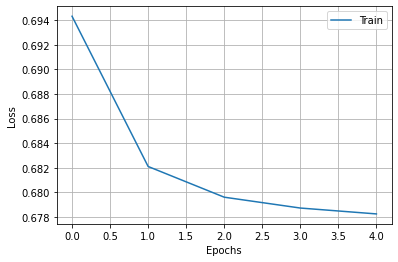

In [48]:
plt.plot(train_losses, label="Train")
#plt.plot(valid_losses, label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

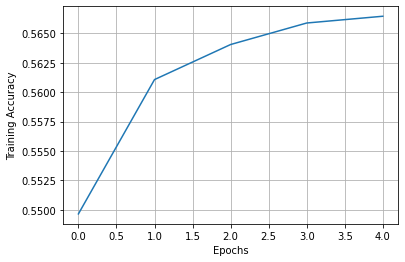

In [49]:
plt.plot(train_accs)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.grid()

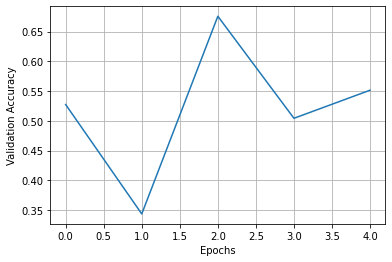

In [50]:
plt.plot(valid_accs)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.grid()

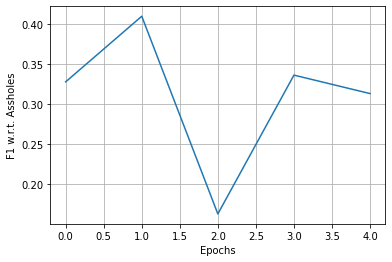

In [51]:
plt.plot(valid_f1s_ass)
plt.xlabel("Epochs")
plt.ylabel("F1 w.r.t. Assholes")
plt.grid()

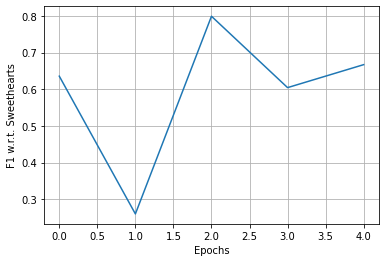

In [52]:
plt.plot(valid_f1s_sweet)
plt.xlabel("Epochs")
plt.ylabel("F1 w.r.t. Sweethearts")
plt.grid()

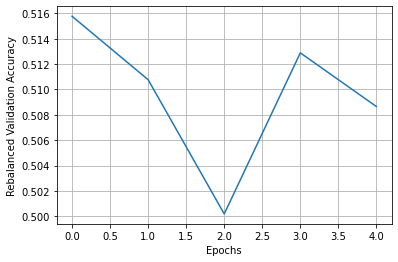

In [53]:
plt.plot(valid_reb_accs)
plt.xlabel("Epochs")
plt.ylabel("Rebalanced Validation Accuracy")
plt.grid()